In [9]:
import os
from pathlib import Path
from gurobipy import Model, GRB
from data_loader import load_prices, load_storage, load_efficiency, load_plant_capacity, load_demand

# Data Loading from data folder in the parent directory
current_dir = Path().resolve()
data_folder = os.path.join(current_dir.parent, "data")
fuel_prices_file = os.path.join(data_folder, "fuel_prices.csv")            # Price in EUR/tonne (coal,oil) or EUR/m3 (gas)
storage_file = os.path.join(data_folder, "storage.csv")                    # Max storage in tonnes/m3
efficiency_file = os.path.join(data_folder, "efficiency.csv")              # efficiency of MWh th to MWh el
plant_file = os.path.join(data_folder, "plant_capacity.csv")               # Plant capacity in MWh/month
demand_file = os.path.join(data_folder, "electricity_demand.csv")          # Monthly demand in MWh

start_date = "2020-01"
end_date = "2020-12"

fuels = ["coal", "oil", "gas"]
zone = 'DK_2'

try:
    fuel_prices_df = load_prices(fuel_prices_file, start_date, end_date)
    storage = load_storage(storage_file)
    efficiency = load_efficiency(efficiency_file)
    plant_capacity = load_plant_capacity(plant_file)
    demand_df = load_demand(demand_file, start_date, end_date, zone=zone ,supply_factor=0.0005)
except Exception as e:
    raise RuntimeError(f"Error loading data: {e}")


# Timesteps
T = list(range(len(demand_df)))

# Model Initialization

m = Model("Fuel_Procurement_OneMonth")

F = [fuel for fuel in fuel_prices_df.columns if fuel in fuels]

# Decision Variables
# Decision Variables (corrected filters)
x = {(fuel, t): m.addVar(lb=0, ub=storage[fuel], name=f"buy_{fuel}_{t}")
     for fuel in F for t in T}

y = {(fuel, t): m.addVar(lb=0, ub=plant_capacity[fuel], name=f"gen_{fuel}_{t}")
     for fuel in F for t in T}

s = {(fuel, t): m.addVar(lb=0, ub=storage[fuel], name=f"s_{fuel}_{t}")
     for fuel in F for t in T}




m.update()



In [10]:
# Initial Storage Levels
initial_storage = {fuel: 0 for fuel in fuel_prices_df.columns if fuel in fuels}

# Constraints

# --- Add consumption (withdrawal) variables so stored fuel can be used later ---
# w = fuel consumed in a period (units same as storage units MWh th)
w = {(fuel, t): m.addVar(lb=0, ub=storage[fuel], name=f"cons_{fuel}_{t}")
     for fuel in F for t in T}

m.update()

# Demand constraint: one per time period
for t in T:
    m.addConstr(
        sum(y[fuel, t] for fuel in F) >= int(demand_df.iloc[t][zone]),
        name=f"Demand_Constraint_{t}"
    )

# efficiency constraints
for fuel in F:
    for t in T:
        m.addConstr(
            y[fuel, t] == efficiency[fuel] * w[fuel, t],
            name=f"Gen_from_Consumption_{fuel}_{t}"
        )

m.update()

# State-of-energy (SOE) constraints: storage evolves with buys (x) and withdrawals (w)
for fuel in F:
    print(f"Setting up SOE constraints for {fuel}")
    for t in T:
        print(f"  Time period {t}")
        if t == 0:
            m.addConstr(
                s[fuel, t] == initial_storage[fuel] + x[fuel, t] - w[fuel, t],
                name=f"SOE_Def_{fuel}_{t}"
            )
        else:
            m.addConstr(
                s[fuel, t] == s[fuel, t-1] + x[fuel, t] - w[fuel, t],
                name=f"SOE_Def_{fuel}_{t}"
            )

# Storage limits (explicit upper bound)
for fuel in F:
    for t in T:
        m.addConstr(
            s[fuel, t] <= storage[fuel],
            name=f"SOE_Limit_{fuel}_{t}"
        )

# Cyclic SOE (start == end)
t0 = 0
t4 = T[-1]   # last period
for fuel in F:
    m.addConstr(
        s[fuel, t0] == s[fuel, t4],
        name=f"SOE_Cycle_{fuel}"
    )

# Objective
m.setObjective(
    sum(fuel_prices_df.iloc[t][fuel] * x[fuel, t] for fuel in F for t in T),
    GRB.MINIMIZE
)
m.update()

# Optimize
m.optimize()

# print results
if m.status == GRB.OPTIMAL:
    print("Optimal Solution Found:")
    # Purchased and generated per fuel and period
    for (fuel, t) in sorted(x.keys()):
        print(f"Purchased {x[fuel, t].X:.4f} units of {fuel} at period {t}")
    for (fuel, t) in sorted(y.keys()):
        print(f"Generated {y[fuel, t].X:.4f} MWh from {fuel} at period {t}")
    for (fuel, t) in sorted(s.keys()):
        print(f"Stored {s[fuel, t].X:.4f} units of {fuel} at period {t}")

    # Cost per fuel aggregated across periods
    total_cost = 0.0
    for fuel in F:
        cost_f = sum(fuel_prices_df.iloc[t][fuel] * x[fuel, t].X for t in T)
        print(f"Cost for {fuel}: EUR {cost_f:.2f}")
        total_cost += cost_f

    print(f"Total Cost: EUR {total_cost:.2f}")
else:
    print("No optimal solution found.")


Setting up SOE constraints for coal
  Time period 0
  Time period 1
  Time period 2
  Time period 3
  Time period 4
  Time period 5
  Time period 6
  Time period 7
  Time period 8
  Time period 9
  Time period 10
  Time period 11
Setting up SOE constraints for oil
  Time period 0
  Time period 1
  Time period 2
  Time period 3
  Time period 4
  Time period 5
  Time period 6
  Time period 7
  Time period 8
  Time period 9
  Time period 10
  Time period 11
Setting up SOE constraints for gas
  Time period 0
  Time period 1
  Time period 2
  Time period 3
  Time period 4
  Time period 5
  Time period 6
  Time period 7
  Time period 8
  Time period 9
  Time period 10
  Time period 11
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



Optimize a model with 123 rows, 144 columns and 291 nonzeros
Model fingerprint: 0x49f34b6a
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [4e+00, 5e+01]
  Bounds range     [4e+02, 1e+04]
  RHS range        [5e+02, 1e+04]
Presolve removed 75 rows and 39 columns
Presolve time: 0.00s
Presolved: 48 rows, 105 columns, 177 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.613250e+03   0.000000e+00      0s
      34    6.9814046e+04   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.981404617e+04
Optimal Solution Found:
Purchased 1607.8947 units of coal at period 0
Purchased 1518.4211 units of coal at period 1
Purchased 1526.3158 units of coal at period 2
Purchased 0.0000 units of coal at period 3
Purchased 0.0000 units of coal at period 4
Purchased 0.0000 units of coal at period 5
Purchased 0.0000 units of coal at period 6
Purchased 0.0000 uni

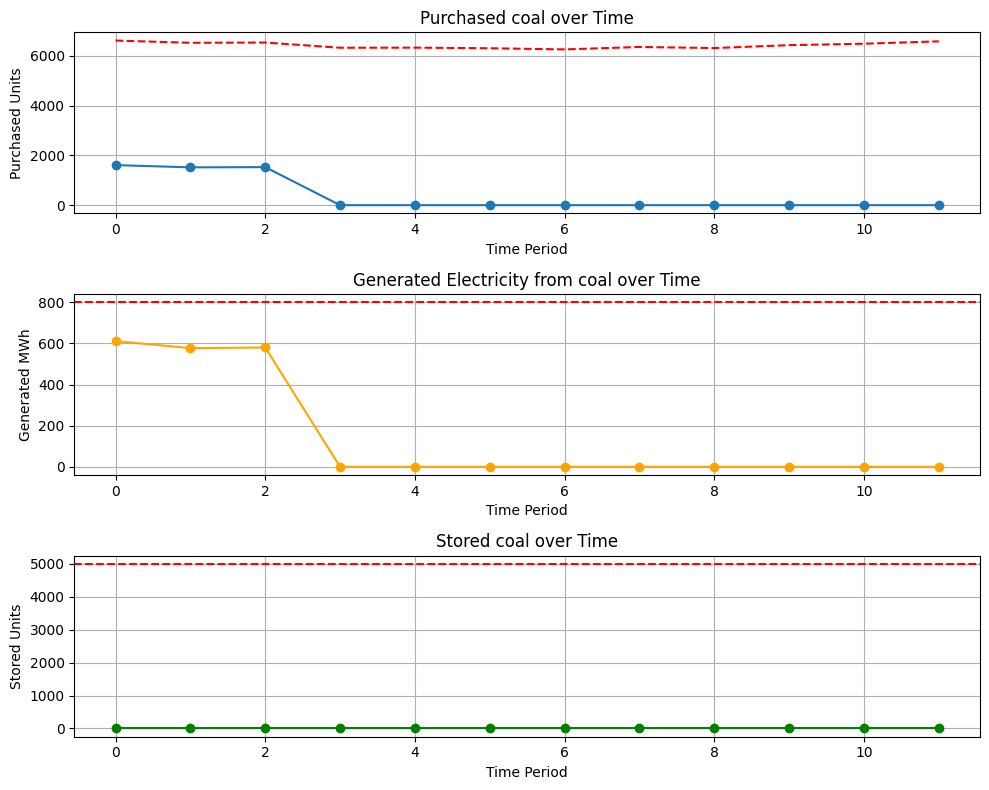

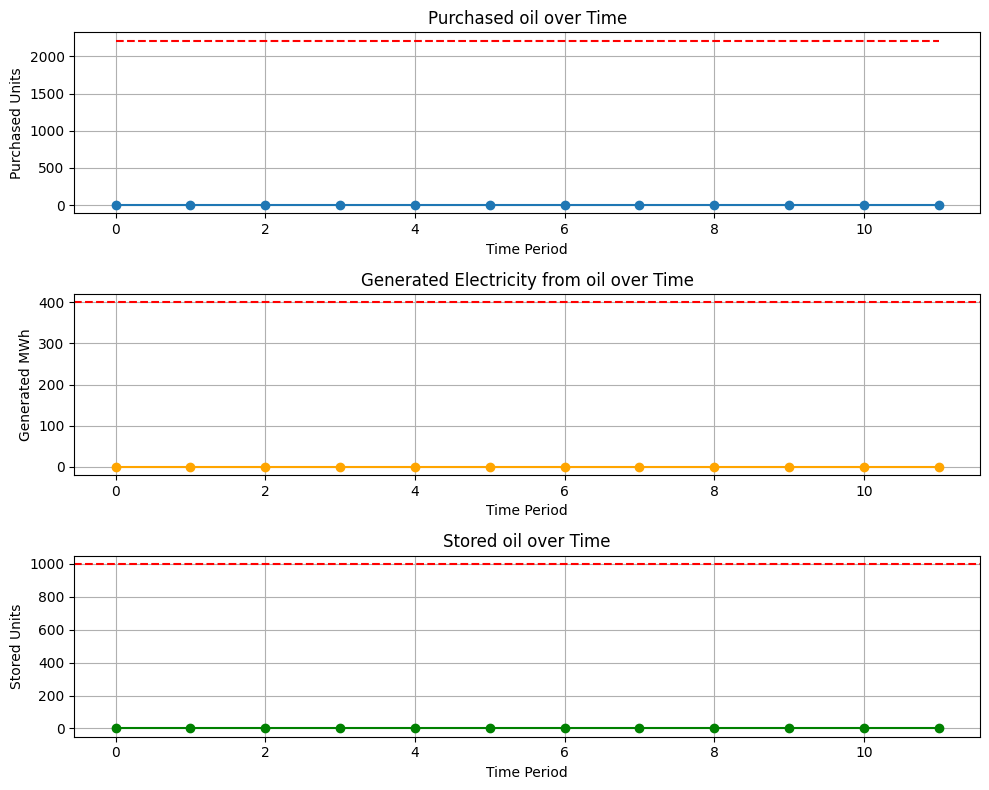

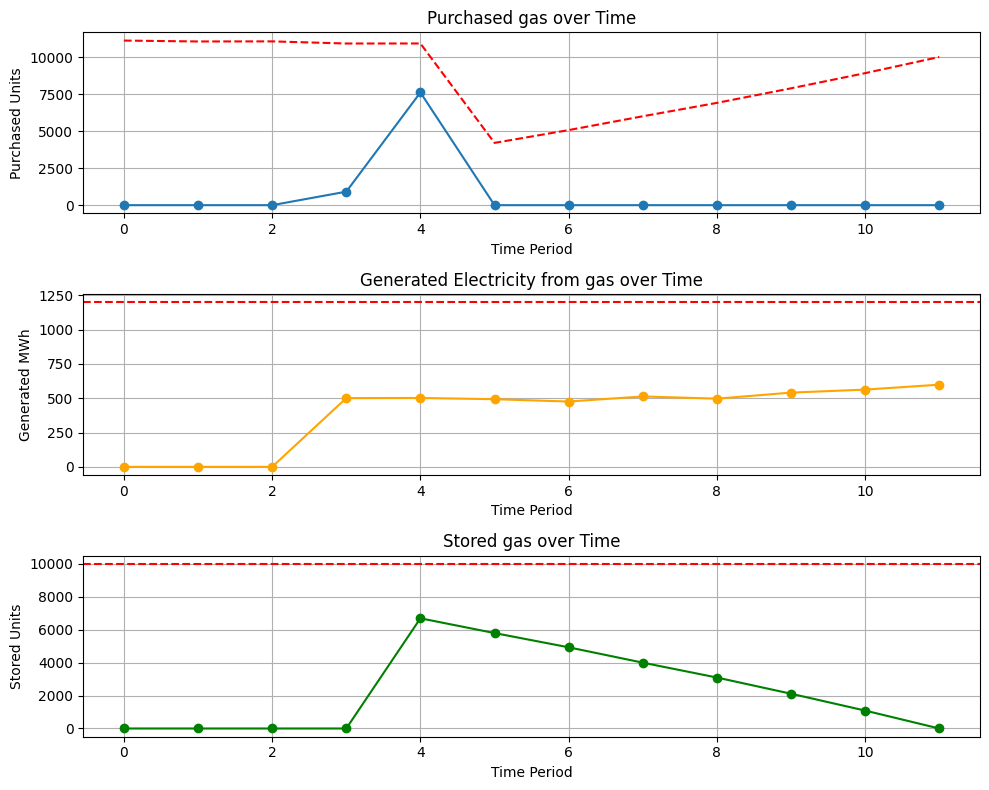

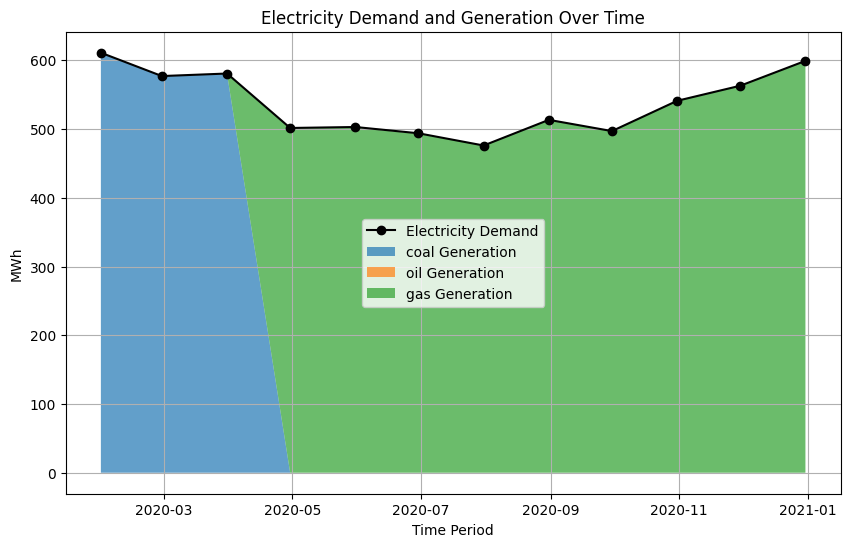

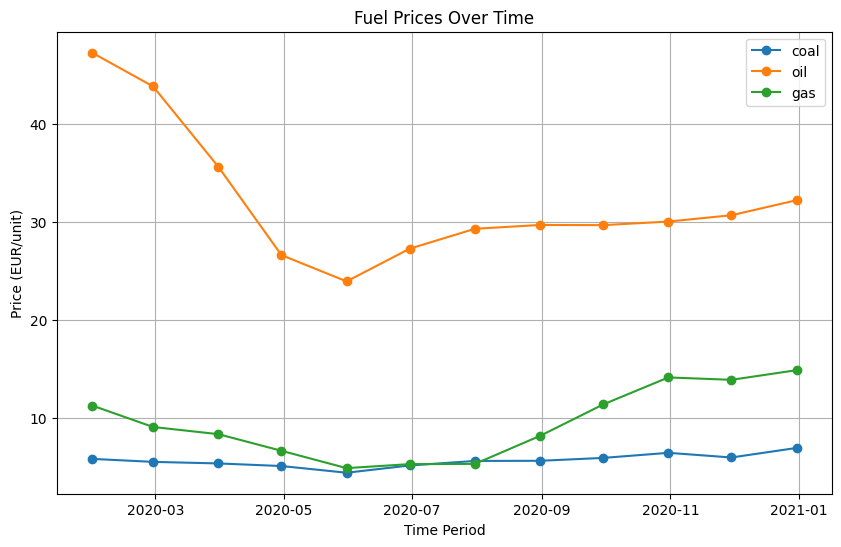

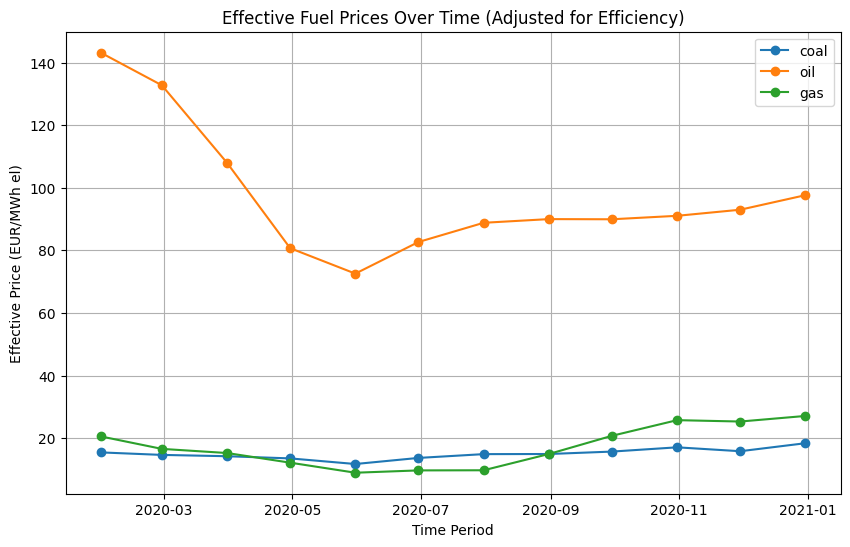

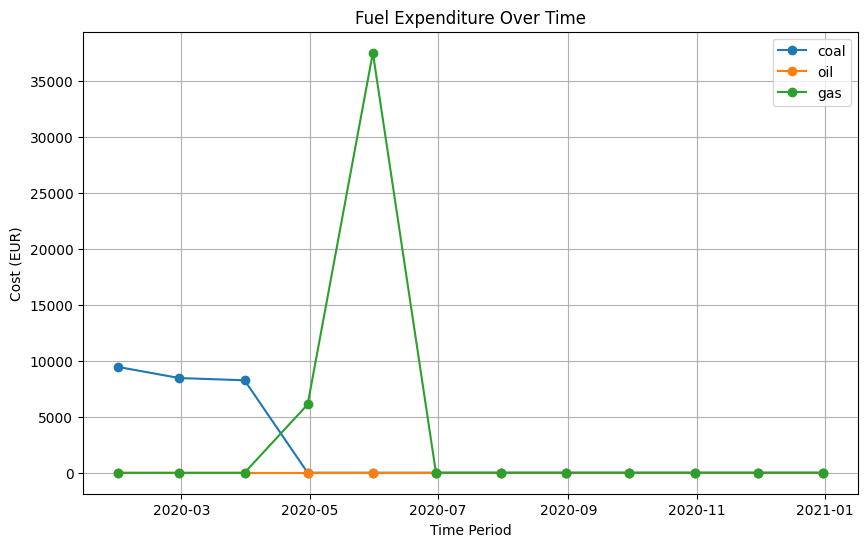

In [11]:
# plot purchased, generated, and stored fuel over time with a red line showing maximum plant capacity, and storage capacity respectively
import matplotlib.pyplot as plt

time_periods = [t for t in T]

for fuel in F:
    purchased = [x[fuel, t].X for t in T]
    generated = [y[fuel, t].X for t in T]
    stored = [s[fuel, t].X for t in T]
    efficiency_corrected_demand = [float(demand_df.iloc[t][zone]) / efficiency[fuel] for t in T]
    # Get maximum purchase capacity by calculating leftover storage from last round plus either efficiency corrected plant capacity or total demand
    stored_last = [0] + stored[:-1]
    max_purchase_capacity = [storage[fuel] - row + plant_capacity[fuel]/efficiency[fuel] for row in stored_last]
    max_purchase_demand = [ stor + dem for stor,dem in zip([storage[fuel] - row for row in stored_last],
                                                           efficiency_corrected_demand) ]

    max_purchase = [min(cap, dem) for cap, dem in zip(max_purchase_capacity, max_purchase_demand)]

    plt.figure(figsize=(10, 8))
    plt.subplot(3, 1, 1)
    plt.plot(time_periods, purchased, marker='o')
    plt.plot(time_periods,max_purchase, color='r', linestyle='--', label='Leftover Storage + Plant Capacity')
    plt.title(f'Purchased {fuel} over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Purchased Units')
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(time_periods, generated, marker='o', color='orange')
    plt.axhline(y=plant_capacity[fuel], color='r', linestyle='--', label='Max Plant Capacity')
    plt.title(f'Generated Electricity from {fuel} over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Generated MWh')
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(time_periods, stored, marker='o', color='green')
    plt.axhline(y=storage[fuel], color='r', linestyle='--', label='Max Storage Capacity')
    plt.title(f'Stored {fuel} over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Stored Units')
    plt.grid()

    plt.tight_layout()
    plt.show()


# Plot demand over time employing fill_between to show contributions from each fuel
plt.figure(figsize=(10, 6))
plt.plot(demand_df.index, demand_df[zone], marker='o', label='Electricity Demand', color='black')
bottom = [0]*len(T)
for fuel in F:
    generation = [y[fuel, t].X for t in T]
    plt.fill_between(demand_df.index, bottom, [b + g for b, g in zip(bottom, generation)], label=f'{fuel} Generation', alpha=0.7)
    bottom = [b + g for b, g in zip(bottom, generation)]
plt.title('Electricity Demand and Generation Over Time')
plt.xlabel('Time Period')
plt.ylabel('MWh')
plt.legend()
plt.grid()
plt.show()

# Plot prices over time
plt.figure(figsize=(10, 6))
for fuel in F:
    plt.plot(fuel_prices_df.index, fuel_prices_df[fuel], marker='o', label=fuel)
plt.title('Fuel Prices Over Time')
plt.xlabel('Time Period')
plt.ylabel('Price (EUR/unit)')
plt.legend()
plt.grid()
plt.show()

# plot prices divided by efficiency to see effective cost per MWh electricity
plt.figure(figsize=(10, 6))
for fuel in F:
    effective_price = fuel_prices_df[fuel] / efficiency[fuel]
    plt.plot(fuel_prices_df.index, effective_price, marker='o', label=fuel)
plt.title('Effective Fuel Prices Over Time (Adjusted for Efficiency)')
plt.xlabel('Time Period')
plt.ylabel('Effective Price (EUR/MWh el)')
plt.legend()
plt.grid()
plt.show()

# Plot cost over time
plt.figure(figsize=(10, 6))
for fuel in F:
    cost_over_time = [fuel_prices_df.iloc[t][fuel] * x[fuel, t].X for t in T]
    plt.plot(fuel_prices_df.index, cost_over_time, marker='o', label=fuel)
plt.title('Fuel Expenditure Over Time')
plt.xlabel('Time Period')
plt.ylabel('Cost (EUR)')
plt.legend()
plt.grid()
plt.show()


Total Cost from Model 1: EUR 91305.06
Total Cost from Model 2: EUR 69814.05


Text(0, 0.5, 'Cumulative Cost (EUR)')

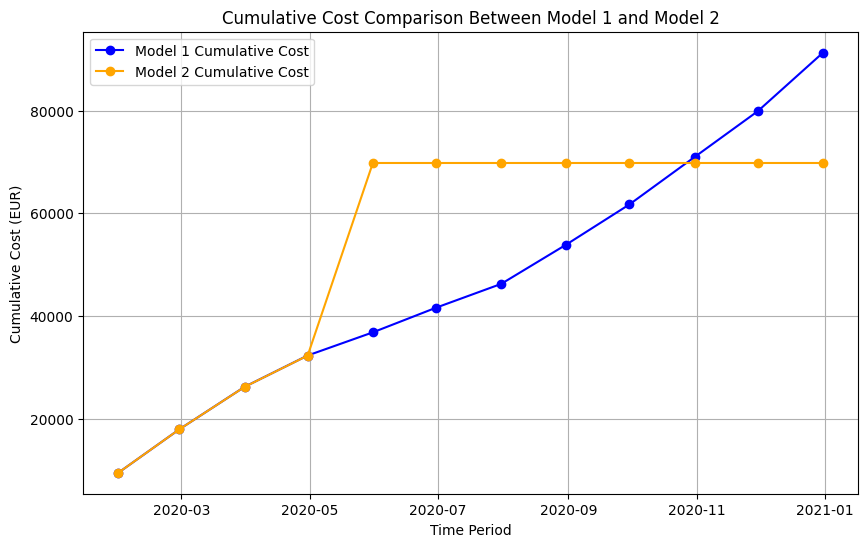

In [12]:
# Compare total cost to Model 1 as stored in Accumulated_Cost column in "results/model1/running_cost_results.csv"
import pandas as pd
model1_results_file = os.path.join(current_dir.parent, "results", "model1", "running_cost_results.csv")
model1_results_df = pd.read_csv(model1_results_file)
model1_total_cost = model1_results_df['Accumulated_Cost'].iloc[-1]
print(f"Total Cost from Model 1: EUR {model1_total_cost:.2f}")
print(f"Total Cost from Model 2: EUR {total_cost:.2f}")
# Compare costs
if abs(total_cost - model1_total_cost) < 1e-2:
    print("Total costs from Model 1 and Model 2 match closely.")

# Results Analysis and Visualization
model2_cost = []
for t in T:
    period_cost = sum(fuel_prices_df.iloc[t][fuel] * x[fuel, t].X for fuel in F)
    model2_cost.append(period_cost)
plt.figure(figsize=(10, 6))
plt.plot(demand_df.index, model1_results_df['Accumulated_Cost'], marker='o', label='Model 1 Cumulative Cost', color='blue')
plt.plot(demand_df.index, pd.Series(model2_cost).cumsum(), marker='o', label='Model 2 Cumulative Cost', color='orange')
plt.legend()
plt.title('Cumulative Cost Comparison Between Model 1 and Model 2')
plt.grid()
plt.xlabel('Time Period')
plt.ylabel('Cumulative Cost (EUR)')